**IMPORT LIBRARY**

Importing all required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, load_img
import zipfile

In [ ]:
# Cek versi untuk setiap library
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("tensorflow version:", tf.__version__)


matplotlib version: 3.8.0
numpy version: 1.26.4
pandas version: 2.2.2
seaborn version: 0.13.2
tensorflow version: 2.17.1


**IMPORT DATASET FROM KAGGLE**

Import dataset from kaggle using kaggle API, previously you have to download your API on Kaggle first

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dasa7753912/new-paddy-doctor-paddy-disease-classification

Dataset URL: https://www.kaggle.com/datasets/dasa7753912/new-paddy-doctor-paddy-disease-classification
License(s): unknown
 99% 2.15G/2.17G [00:20<00:00, 110MB/s] 
100% 2.17G/2.17G [00:20<00:00, 115MB/s]


**EXTRACT THE DOWNLOADED DATASET**

In [ ]:
!unzip -q new-paddy-doctor-paddy-disease-classification.zip

**DELETING ZIP FILES**

In [ ]:
rm new-paddy-doctor-paddy-disease-classification.zip

**DELETING UNNECESSARY DISEASE IMAGES FROM THE train_images FOLDER IN THE paddy-disease-classification FOLDER**

Because we only want to use the bacterial_leaf_blight, blast, brown_spot, normal and tungro datasets, we have to delete the datasets that are not needed

In [ ]:
# Create a list of folder names to delete.
folders_to_remove = [
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'dead_heart',
    'downy_mildew',
    'hispa'
]

# Delete each folder in an iterative manner
base_path = '/content/paddy-disease-classification/train_images/'
for folder in folders_to_remove:
    shutil.rmtree(base_path + folder)


**SPLITTING DATASET FOR MODEL VALIDATION**

Because in the dataset there is no folder for image validation, therefore we have to create one for image validation

In [ ]:
dataset_path = "/content/paddy-disease-classification"
train_dir = os.path.join(dataset_path, "train_images")

In [ ]:
validation_dir = os.path.join(dataset_path, "validation_images")
os.makedirs(validation_dir, exist_ok=True)

In [ ]:
for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    validation_class_path = os.path.join(validation_dir, cls)
    os.makedirs(validation_class_path, exist_ok=True)
    images = os.listdir(class_path)
    np.random.shuffle(images)
    validation_count = int(0.2 * len(images)) #we use 20% (0.2) of images for validation
    for img in images[:validation_count]:
        shutil.move(os.path.join(class_path, img), os.path.join(validation_class_path, img))

**Exploratory Data Analysis of the dataset**

Perform Exploratory Data Analysis on the dataset to determine the number of files

Number of Classes: 5
Name of Classes: ['brown_spot', 'bacterial_leaf_blight', 'normal', 'blast', 'tungro']


<ipython-input-14-836db0a60cd9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette=colors)


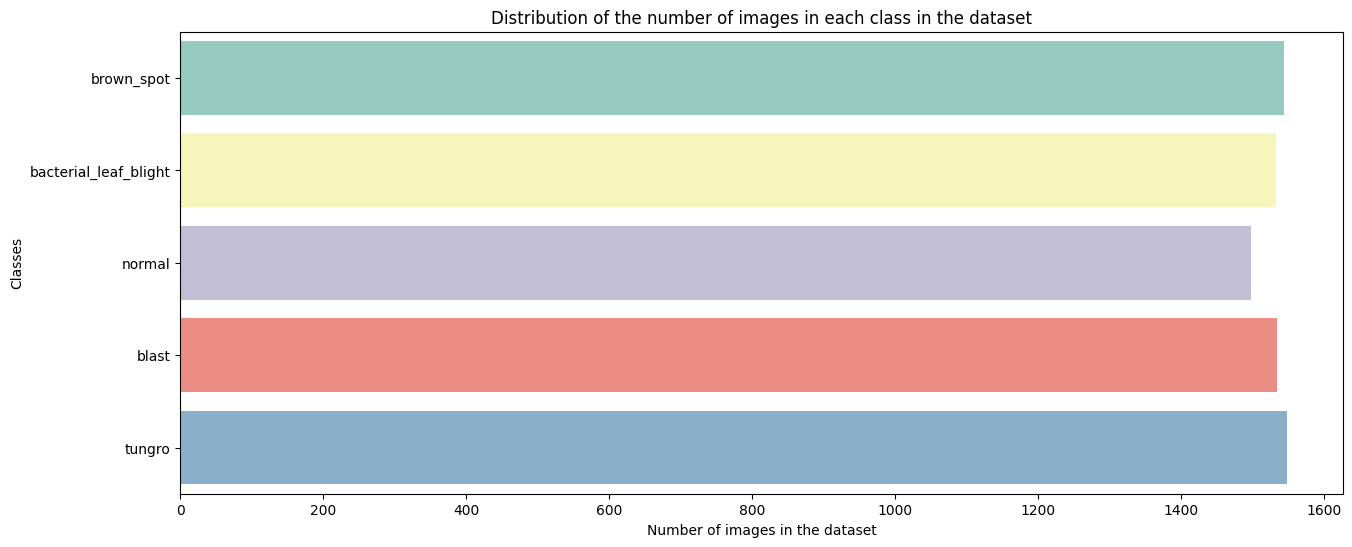

In [ ]:
def perform_eda_on_dataset(train_dir):
    classes = os.listdir(train_dir)
    print(f"Number of Classes: {len(classes)}")
    print(f"Name of Classes: {classes}")

    class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
    colors = sns.color_palette("Set3", len(classes))

    plt.figure(figsize=(15, 6))
    sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette=colors)
    plt.xticks()
    plt.title("Distribution of the number of images in each class in the dataset")
    plt.xlabel("Number of images in the dataset")
    plt.ylabel("Classes")
    plt.show()

perform_eda_on_dataset(train_dir)

**IMAGE AUGMENTATION**

"Image augmentation" is performed to increase the variety of images to be trained and validated

In [ ]:
train_datagenerator = ImageDataGenerator( rescale=1.0/255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagenerator = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagenerator.flow_from_directory(train_dir, target_size=(224, 224), batch_size=64, class_mode='categorical')

validation_generator = val_datagenerator.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=64, class_mode='categorical')

Found 7659 images belonging to 5 classes.
Found 1913 images belonging to 5 classes.


**CLASS WEIGHTING ON DATA**

Class weighting is done because the data distribution is uneven

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
ClassLabels = list(train_generator.class_indices.keys())
ClassWeights = compute_class_weight(  class_weight='balanced', classes=np.arange(len(ClassLabels)),
                                      y=np.concatenate([np.full(len(train_generator.filepaths[i]), i) for i in range(len(ClassLabels))])
                                    )

ClassWeightsDict = {i: ClassWeights[i] for i in range(len(ClassWeights))}
print("Class Weights In Dataset:", ClassWeightsDict)

Class Weights In Dataset: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


**PRE TRAIN MODEL**

In [ ]:
model = tf.keras.models.Sequential([  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(229, 229, 3)),
                                      tf.keras.layers.MaxPooling2D(2, 2),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(128, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(5, activation='softmax') #because the output is more than 2, therefore we use softmax activation
                                  ])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 227, 227, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,887,109 (18.64 MB)

 Trainable params: 4,887,109 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator, class_weight=ClassWeightsDict, verbose=1)

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 786ms/step - accuracy: 0.4007 - loss: 1.4027 - val_accuracy: 0.4569 - val_loss: 1.2340
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 779ms/step - accuracy: 0.4734 - loss: 1.2493 - val_accuracy: 0.5515 - val_loss: 1.1153
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 779ms/step - accuracy: 0.5629 - loss: 1.1002 - val_accuracy: 0.6268 - val_loss: 0.9872
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 781ms/step - accuracy: 0.5872 - loss: 1.0329 - val_accuracy: 0.6095 - val_loss: 0.9781
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 779ms/step - accuracy: 0.6099 - loss: 0.9737 - val_accuracy: 0.6587 - val_loss: 0.8784


**USING TRANSFER LEARNING (EfficientNetB2)**

In [ ]:
TransferLearning_Model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
TransferLearning_Model.trainable = True

In [ ]:
x = TransferLearning_Model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs=TransferLearning_Model.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 8,162,814 (31.14 MB)

 Trainable params: 8,095,239 (30.88 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=65,
    validation_data=validation_generator,
    class_weight=ClassWeightsDict,
    verbose=1
)

Epoch 1/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2187 - loss: 1.6850 - val_accuracy: 0.2023 - val_loss: 1.6250
Epoch 2/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 793ms/step - accuracy: 0.2934 - loss: 1.5711 - val_accuracy: 0.2007 - val_loss: 1.6383
Epoch 3/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 800ms/step - accuracy: 0.3454 - loss: 1.4948 - val_accuracy: 0.2133 - val_loss: 1.6405
Epoch 4/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 797ms/step - accuracy: 0.4380 - loss: 1.3669 - val_accuracy: 0.1976 - val_loss: 1.6604
Epoch 5/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 792ms/step - accuracy: 0.4932 - loss: 1.2393 - val_accuracy: 0.2462 - val_loss: 1.6600
Epoch 6/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 789ms/step - accuracy: 0.5623 - loss: 1.1057 - val_accuracy: 0.4417 - val_loss: 1.3356
Epoch 7/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 792ms/step - accuracy: 0.6065 - loss: 0.9935 - val_accuracy: 0.5870 - val_loss: 1.0546
Epoch 8/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 790ms/step - accuracy: 0.6435 - lo

**PLOT FOR ACCURACY AND LOSS**

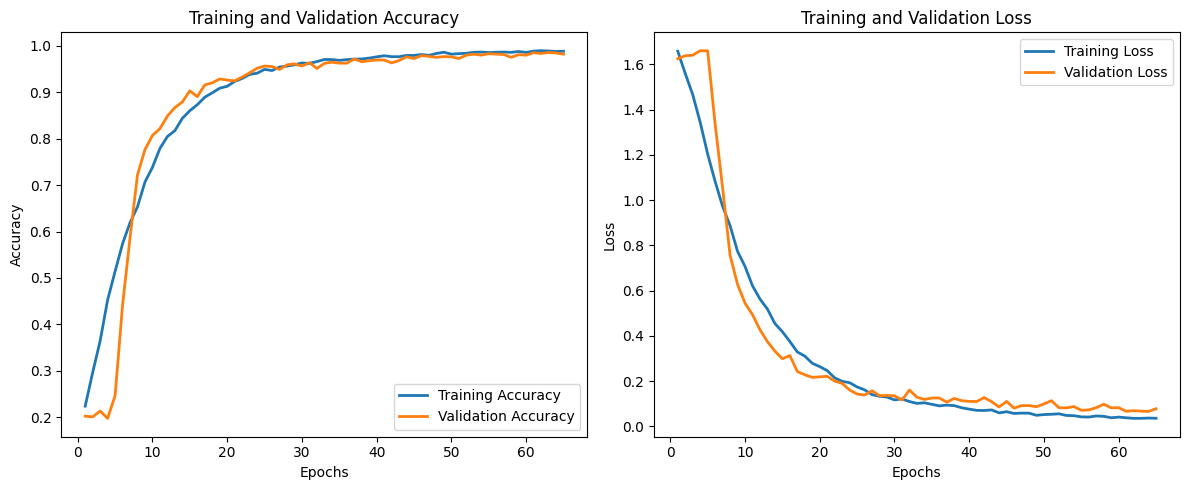

In [ ]:
import matplotlib.pyplot as plt

def PlotTrainingHistory(history):
    acc = history.history['accuracy']
    ValidationAccuracy = history.history['val_accuracy']
    loss = history.history['loss']
    ValidationLoss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs, ValidationAccuracy, label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, ValidationLoss, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

PlotTrainingHistory(history)


**USING FINE TUNING**

In [ ]:
TransferLearning_Model.trainable = True

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_fine = model.fit( train_generator,
                          epochs=10,
                          validation_data=validation_generator,
                          class_weight=ClassWeightsDict,
                          verbose=1
                        )

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9883 - loss: 0.0344 - val_accuracy: 0.9838 - val_loss: 0.0663
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 802ms/step - accuracy: 0.9908 - loss: 0.0260 - val_accuracy: 0.9848 - val_loss: 0.0655
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 797ms/step - accuracy: 0.9907 - loss: 0.0309 - val_accuracy: 0.9843 - val_loss: 0.0661
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 795ms/step - accuracy: 0.9904 - loss: 0.0340 - val_accuracy: 0.9848 - val_loss: 0.0645
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 791ms/step - accuracy: 0.9917 - loss: 0.0253 - val_accuracy: 0.9848 - val_loss: 0.0670
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 790ms/step - accuracy: 0.9890 - loss: 0.0394 - val_accuracy: 0.9843 - val_loss: 0.0674
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 795ms/step - accuracy: 0.9932 - loss: 0.0224 - val_accuracy: 0.9843 - val_loss: 0.0691
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 791ms/step - accuracy: 0.9901 - lo

**TESTING**

Saving 107711.jpg to 107711.jpg


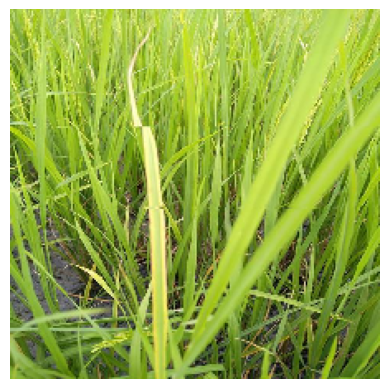

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 0.00%
brown_spot: 100.00%
normal: 0.00%
tungro: 0.00%

Result:
brown_spot: 100.00%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for filepath in uploaded.keys():
    img = image.load_img(filepath, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    proba = model.predict(x, verbose=0)[0]

    print("Prediction probabilities:")
    for label, probability in zip(labels, proba):
        print(f"{label}: {probability * 100:.2f}%")

    MaxIndex = np.argmax(proba)
    MaxLabel = labels[MaxIndex]
    MaxProbability = proba[MaxIndex]

    print("\nResult:")
    if MaxProbability >= 0.5:
        print(f"{MaxLabel}: {MaxProbability * 100:.2f}%")
    else:
        print("Hasil tidak ditemukan!")


**CONFUSSION MATRIX**

Found 1913 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step


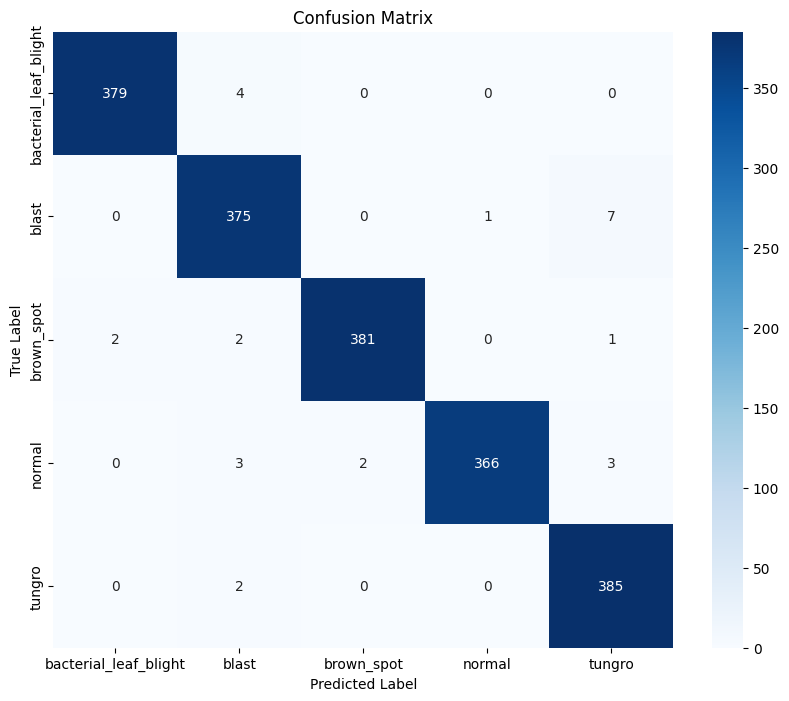

Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.99      0.99       383
                blast       0.97      0.98      0.98       383
           brown_spot       0.99      0.99      0.99       386
               normal       1.00      0.98      0.99       374
               tungro       0.97      0.99      0.98       387

             accuracy                           0.99      1913
            macro avg       0.99      0.99      0.99      1913
         weighted avg       0.99      0.99      0.99      1913



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))


**SAVE THE MODEL**

In [ ]:
model.save('model_RIPAD_PART4.h5')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model_RIPAD_PART4.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model_RIPAD_PART4.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp3qav596o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137539005223456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137539005224512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137539005232080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005231200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005225568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005226448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005230496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005232608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005251824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137539005252352: TensorSpec(shape=(), dtype=tf.resource, name=Non